In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12,8)
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [3]:
records_subset = list(tf.python_io.tf_record_iterator('../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord')) #records holds the array of the tfrecord file
rec_len = len(records_subset)
print(rec_len)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
17662


In [4]:
from bitstring import BitArray  #To perform bit manipulation
from keras.preprocessing.sequence import pad_sequences

def datamatrix_multiclass(tfrecord, start_frac=0, end_frac=1):
    '''
    Shuffles the Audioset training data and returns a generator of training data and boolean laughter labels
    batch_size: batch size for each set of training data and labels
    tfrecord: filestring of the tfrecord file to train on
    start_frac: the starting point of the data set to use, as a fraction of total record length (used for CV)
    end_frac: the ending point of the data set to use, as a fraction of total record length (used for CV)
    '''
    max_len=10
    #tfrecord holds data in binary sequence string. 
    records = list(tf.python_io.tf_record_iterator(tfrecord))  #records holds the array of the tfrecord file
    if(tfrecord == '../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
       
    records = records[int(start_frac*len(records)):int(end_frac*len(records))]  # Make train_set & CV_set 
    print("After fractioning:")
    if(tfrecord == '../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in training dataset:", len(records))
    elif(tfrecord == '../data/preprocessed/eval_gunspotting_in_school_subset.tfrecord'):
        print("Total audioframes in eval dataset:", len(records))
    
    rec_len = len(records)  # this is your train set, rest is CV_set
    shuffle = np.random.permutation(range(rec_len))
    
    
    classes = ["gun","fireworks","glass","hammer", "school","background","tools", "multiclass_nogun" ]
    dict_classes = dict.fromkeys(classes)
    
    gun_labels = [426,427,428,429,430,431]
    fireworks_labels = [432,433,434]
    glass_labels = [441,442,443]
    tools_labels = [418,420,421,422,423,424,425]
    background_labels= [506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526]
    hammer_labels=[419]
    school_labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13]
    #other_labels =[]
    
    while True:
        X = []
        y = []  #add g=[],f=[],b=[],other=[]
        
        for idx in shuffle[0:rec_len]:
            example = records[idx]
            tf_seq_example = tf.train.SequenceExample.FromString(example)
            example_label = list(np.asarray(tf_seq_example.context.feature['labels'].int64_list.value))
            dict_classes = {
                "gun":int(any((True for x in example_label if x in gun_labels))),
                "fireworks":int(any((True for x in example_label if x in fireworks_labels))),
                "glass":int(any(True for x in example_label if x in glass_labels)),
                "hammer":int(any(True for x in example_label if x in hammer_labels)),
                "school":int(any(True for x in example_label if x in school_labels)),
                "tools":int(any(True for x in example_label if x in tools_labels)),
                "background":int(any(True for x in example_label if x in background_labels))
            }
            
            # Class number: gun=0, fireworks=1,glass=2,hammer=3,school=4,tools=5,background=6,multi_nogun=7
            #Handling Mutually exclusive case
            if(sum(dict_classes.values())==1):
                if(dict_classes["gun"]==1):
                    y.append(0)
                if(dict_classes["fireworks"]==1):
                    y.append(1)
                if(dict_classes["glass"]==1):
                    y.append(2)
                if(dict_classes["hammer"]==1):
                    y.append(3)
                if(dict_classes["school"]==1):
                    y.append(4)
                if(dict_classes["tools"]==1):
                    y.append(5)
                if(dict_classes["background"]==1):
                    y.append(6)
               
            #Two classes occuring at once -- class which have low no. of samples data is given high priority  
            if((sum(dict_classes.values())==2)):
                if(dict_classes["gun"] == 1):
                    y.append(0)
                    print("co-occurrence of gun class with someother class")
                elif(dict_classes["hammer"]==1):
                    y.append(3)
                elif(dict_classes["fireworks"]==1):
                    y.append(1)
                elif(dict_classes["glass"]==1):
                    y.append(2)
                elif(dict_classes["tools"]==1):
                    y.append(5)
                elif(dict_classes["school"]==1):
                    y.append(4)
                else:
                    y.append(6) #background
            
              #For >3 co-occurrence
            if((sum(dict_classes.values())>=3)):
                if(dict_classes["gun"] == 1):
                    y.append(0)
                    print("co-occurrence of gun class with >=3 class")
                else:
                    y.append(7)
               
            n_frames = len(tf_seq_example.feature_lists.feature_list['audio_embedding'].feature)
            audio_frame = []
            for i in range(n_frames):
                audio_frame.append(np.frombuffer(tf_seq_example.feature_lists.feature_list['audio_embedding'].
                                                         feature[i].bytes_list.value[0],np.uint8).astype(np.float32)) # audio_frame gets 128 8 bit numbers on each for loop iteration
            #adding averaging
            avg_audioframe = np.mean(audio_frame, axis = 0)
            
            #comment bottom
#             audio_frame += pad
            X.append(avg_audioframe) 

#         j += 1
#         if j >= num_batches:
#             shuffle = np.random.permutation(range(rec_len))
#             j = 0

        X = np.array(X)
        print("size of X",len(X))
        print("size of y",len(y))
        return X, np.array(y)

In [5]:
audio_train,labels_train = datamatrix_multiclass('../data/preprocessed/bal_gunspotting_in_school_subset.tfrecord')
print(labels_train[labels_train==0].shape) 

Total audioframes in training dataset: 17662
After fractioning:
Total audioframes in training dataset: 17662
co-occurrence of gun class with >=3 class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurre

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurre

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of

co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother clas

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class w

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-o

co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun c

co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class w

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun c

co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with >=3 class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
co-occurrence of gun class with someother class
size of X 17662
size of y 17662
(8831,)


In [6]:
print("Dimension of training matrix:",len(audio_train),"x",len(audio_train[0]))

Dimension of training matrix: 17662 x 128


In [7]:
print(audio_train[0])
# print(len(audio_train[0][0]))
print(type(audio_train[0]))
print(type(audio_train[0][0]))

print((audio_train[0]).shape)
print(audio_train[0][0].shape)


[ 46.3 149.8 165.7 202.2  98.2 194.4 203.4 170.5 127.8 113.9 143.2  21.7
 160.4 127.8 102.7  30.9  28.  252.9 171.4 139.6 166.5 101.5 222.8 196.4
  20.4 171.4 208.8 227.6  26.  152.  229.6  33.8  42.   34.3  38.7  73.6
  54.9 116.4 177.9  36.4 115.5 108.6 217.6  75.3 138.7 159.  226.8  24.8
  94.   34.2 228.4 112.4 131.3 183.6  44.  238.9 196.6  36.4 204.2  33.4
  68.7  32.1  32.2 224.  195.6 190.5  35.2 105.8  38.   59.8 154.  146.8
 145.7 106.3 182.6 145.  192.5 211.9  18.  229.2 127.3 165.7 225.4  65.4
  47.9  79.2  22.6 146.2 219.8 154.   43.  166.4 215.4 172.8  29.1 204.7
 213.5 212.2 225.8 185.2 215.8  23.2 229.6 106.2 217.4 198.9  21.  206.
  22.4 174.2  80.1 221.7 145.9  28.  198.6  85.6 202.9  50.5 158.2  23.4
 216.1 103.4 200.3 118.8  35.9 149.   44.6 208.9]
<class 'numpy.ndarray'>
<class 'numpy.float32'>
(128,)
()


In [8]:
labels_train


array([4, 0, 4, ..., 4, 4, 0])

In [ ]:
gun_count=0
background_count = 0
firework_count = 0
other_count =0 
for i in range(0,len(labels_train)):
    if(labels_train[i] == 0):
        gun_count = gun_count+1
    if(labels_train[i] == 2):
        background_count = background_count+1
    if(labels_train[i] == 1):
        firework_count = firework_count+1
    if(labels_train[i] == 3):
        other_count= other_count+1
print("gun labels:",gun_count)
print("firework labels:",firework_count)
print("background labels:",background_count)
print("other labels:",other_count)

In [ ]:
# %pylab inline
# # import mdtraj as md
# from sklearn.decomposition import PCA


# def get_pca(features):
#     pca = PCA(n_components=2)
#     transformed = pca.fit(features).transform(features)
#     scaler = MinMaxScaler()
#     scaler.fit(transformed)
#     return scaler.transform(transformed)

# pca_vggish = get_pca(audio_train)

# print(pca_vggish.shape)

# mfcc_key = 'pca_vggish'

# # all_json[mfcc_key] = transform_numpy_to_json(pca_vggish)
# #all_json[wavenet_key] = transform_numpy_to_json(pca_wavenet)

# plt.figure(figsize=(30, 30))
# _ = plt.scatter(pca_vggish.T[0],
#                 pca_vggish.T[1])#, pca_vggish.T[2])
# xlabel('PC1')
# ylabel('PC2')
# title('Plot of Embeddings along the PC vectors')
# plt.show()

# # ax = plt.axes(projection='3d')
# # ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

Explained variation per principal component: [0.08778197 0.05023969 0.03026644]


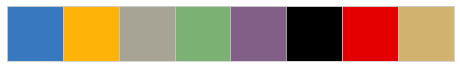

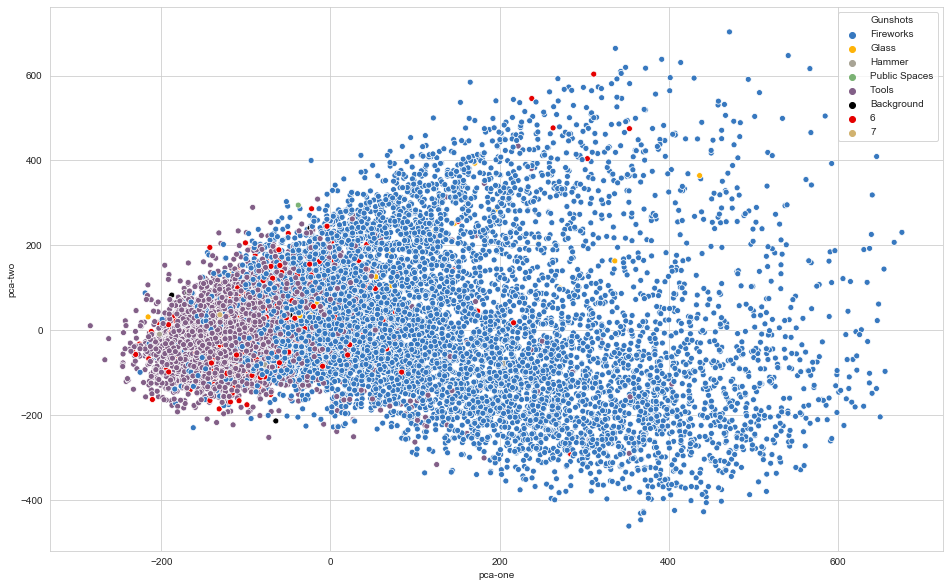

In [13]:
# import mdtraj as md
from sklearn.decomposition import PCA

import seaborn as sns


#PCA in 3 dimensions
df_pca  = pd.DataFrame(audio_train)
df_pca['y'] = labels_train
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_pca) #audio_train)
df_pca['pca-one'] = pca_result[:,0]
df_pca['pca-two'] = pca_result[:,1] 
df_pca['pca-three'] = pca_result[:,2]
# Now you have 3 more coloumns on your df_pca dataframe
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#Explained variation per principal component: [0.09746116 0.07155445 0.06149531]

# For reproducability of the results
np.random.seed(42)
rndperm = np.random.permutation(df_pca.shape[0])

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple","black", "red","tan"]
sns.palplot(sns.xkcd_palette(colors))
# sns.palplot(sns.hls_palette(8, l=.3, s=.8))
# two dimensional plot
plt.figure(figsize=(16,10))
sns.set_style("whitegrid")
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue= "y",
    palette = sns.xkcd_palette(colors),
#     palette=sns.color_palette("husl", 8),
#     palette=sns.hls_palette(4, l=.3, s=.8),
#     palette=sns.color_palette("cubehelix", 4),
    data=df_pca.loc[rndperm,:],
#     legend="full",
#     alpha=1
    legend="full",
)

# Class number: gun=0, fireworks=1,glass=2,hammer=3,school=4,tools=5,background=6,multi_nogun=7

L=plt.legend()
L.get_texts()[0].set_text('Gunshots')
L.get_texts()[1].set_text('Fireworks')
L.get_texts()[2].set_text('Glass')
L.get_texts()[3].set_text('Hammer')
L.get_texts()[4].set_text('Public Spaces')
L.get_texts()[5].set_text('Tools')
L.get_texts()[6].set_text('Background')
# L.get_texts()[7].set_text('Multiclass Nongun')
plt.savefig("PCA_training_data.png", dpi=400)
# # title
# new_title = 'PCA'
# # g.legend.set_title(new_title)
# # replace labels
# new_labels = ['gunshots', 'fireworks', 'glass','hammer','school','tools','background','multi_nogun']
# for t, l in zip(g.legend.texts, new_labels): t.set_text(l)

#Class number: gun=0, fireworks=1,glass=2,hammer=3,school=4,tools=5,background=6,multi_nogun=7

# # three dimensional PCA plot
# plt.figure(figsize=(16,10))#.gca(projection='3d')
# scatter(
#     x=df_pca.loc[rndperm,:]["pca-one"], 
#     y=df_pca.loc[rndperm,:]["pca-two"], 
#     z=df_pca.loc[rndperm,:]["pca-three"], 
#     c=df_pca.loc[rndperm,:]["y"], 
# #     cmap='tab10'
# )
# ax.set_xlabel('pca-one')
# ax.set_ylabel('pca-two')
# ax.set_zlabel('pca-three')
# plt.show()

# # With Seaborn
# from matplotlib.pyplot import figure
# figure(figsize=(16, 10))
# sns.scatterplot(x='AveRooms', y='AveBedrms', data=train_df, 
#                 label="Average Bedrooms");


# # Attributes of interest
# cols = ['density', 
#         'residual sugar', 
#         'total sulfur dioxide', 
#         'fixed acidity', 
#         'wine_type']
        
# pp = sns.pairplot(data=wines[cols], 
#                   hue='wine_type', # <== 😀 Look here!
#                   size=1.8, aspect=1.8, 
#                   palette={"red": "#FF9999", "white": "#FFE888"},
#                   plot_kws=dict(edgecolor="black", linewidth=0.5))
# fig = pp.fig 
# fig.subplots_adjust(top=0.93, wspace=0.3)
# fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

# # trial 3
# cols = ['pca-one', 'pca-two', 'pca-three']
# pp = sns.pairplot(data = df_pca[cols], hue = df_pca['y'].T, size = 1.8, aspect=1.8, palette={"red": "#FF9999", "white": "#FFE888"},
#                   plot_kws=dict(edgecolor="black", linewidth=0.5))

# fig = pp.fig
# fig.subplots_adjust(top=0.93, wspace=0.3)
# fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)



In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import MinMaxScaler
# #default perplexity = 30, iteration = 250 atleast
# embedding = TSNE(n_components=2,
#                      perplexity=40,
#                      n_iter=iteration).fit_transform(audio_train)

In [ ]:
# print("shape of embeddings: ", embedding.shape)

In [17]:
plt.figure(figsize=(16, 10))
_ = plt.scatter(embedding[0],
                embedding[1])#, pca_vggish.T[2])
xlabel('tSNE 0')
ylabel('tSNE 1')
title('Plot of Embeddings in tSNE space')
plt.show()

NameError: name 'embedding' is not defined

<Figure size 1152x720 with 0 Axes>

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 17662 samples in 0.121s...
[t-SNE] Computed neighbors for 17662 samples in 81.364s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17662
[t-SNE] Computed conditional probabilities for sample 2000 / 17662
[t-SNE] Computed conditional probabilities for sample 3000 / 17662
[t-SNE] Computed conditional probabilities for sample 4000 / 17662
[t-SNE] Computed conditional probabilities for sample 5000 / 17662
[t-SNE] Computed conditional probabilities for sample 6000 / 17662
[t-SNE] Computed conditional probabilities for sample 7000 / 17662
[t-SNE] Computed conditional probabilities for sample 8000 / 17662
[t-SNE] Computed conditional probabilities for sample 9000 / 17662
[t-SNE] Computed conditional probabilities for sample 10000 / 17662
[t-SNE] Computed conditional probabilities for sample 11000 / 17662
[t-SNE] Computed conditional probabilities for sample 12000 / 17662
[t-SNE] Computed conditional probabilities for s

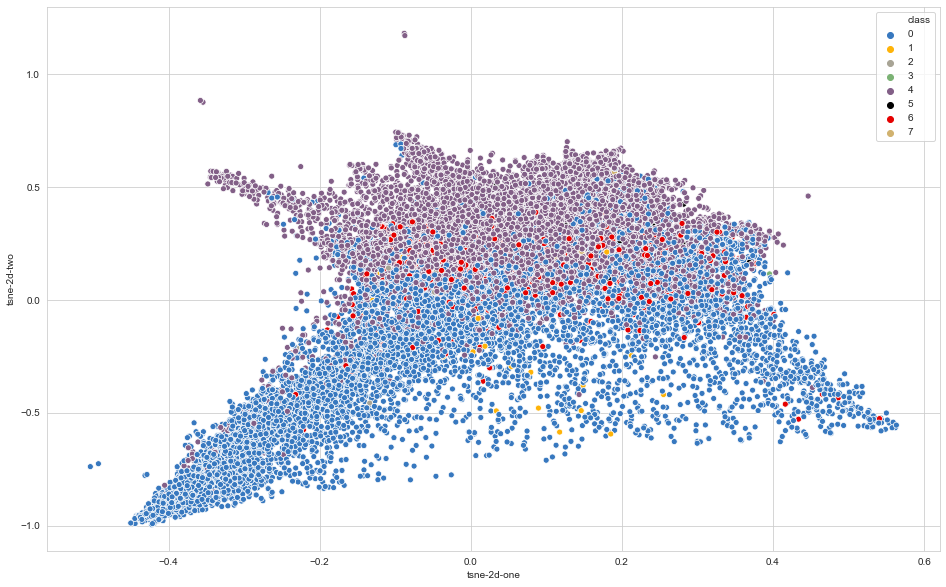

In [21]:
from sklearn.manifold import TSNE
# from sklearn.preprocessing import MinMaxScaler
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette = sns.xkcd_palette(colors),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finshed the cell')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 17662 samples in 0.125s...
[t-SNE] Computed neighbors for 17662 samples in 84.808s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17662
[t-SNE] Computed conditional probabilities for sample 2000 / 17662
[t-SNE] Computed conditional probabilities for sample 3000 / 17662
[t-SNE] Computed conditional probabilities for sample 4000 / 17662
[t-SNE] Computed conditional probabilities for sample 5000 / 17662
[t-SNE] Computed conditional probabilities for sample 6000 / 17662
[t-SNE] Computed conditional probabilities for sample 7000 / 17662
[t-SNE] Computed conditional probabilities for sample 8000 / 17662
[t-SNE] Computed conditional probabilities for sample 9000 / 17662
[t-SNE] Computed conditional probabilities for sample 10000 / 17662
[t-SNE] Computed conditional probabilities for sample 11000 / 17662
[t-SNE] Computed conditional probabilities for sample 12000 / 17662
[t-SNE] Computed conditional probabilities for s

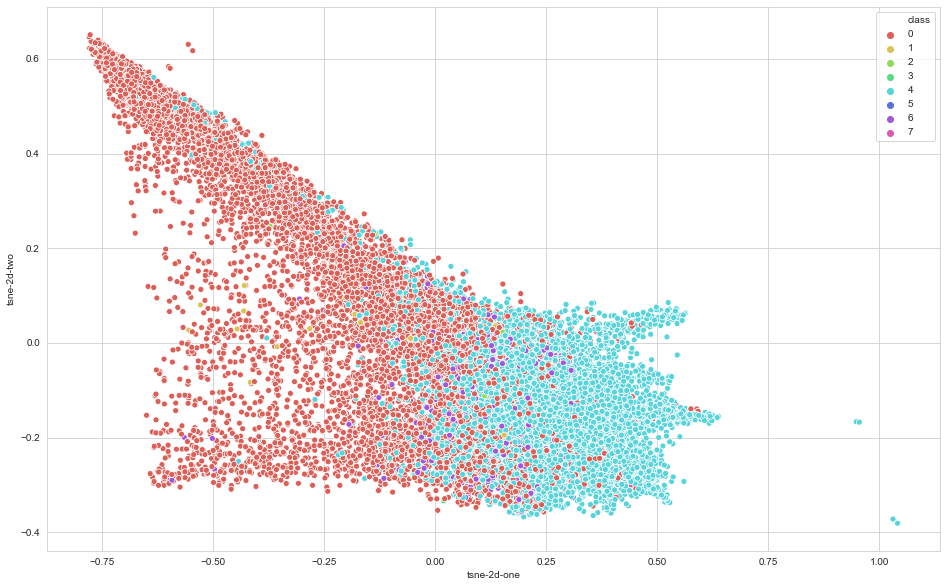

In [33]:
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 8),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

In [34]:
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 17662 samples in 0.123s...
[t-SNE] Computed neighbors for 17662 samples in 84.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17662
[t-SNE] Computed conditional probabilities for sample 2000 / 17662
[t-SNE] Computed conditional probabilities for sample 3000 / 17662
[t-SNE] Computed conditional probabilities for sample 4000 / 17662
[t-SNE] Computed conditional probabilities for sample 5000 / 17662
[t-SNE] Computed conditional probabilities for sample 6000 / 17662
[t-SNE] Computed conditional probabilities for sample 7000 / 17662
[t-SNE] Computed conditional probabilities for sample 8000 / 17662
[t-SNE] Computed conditional probabilities for sample 9000 / 17662
[t-SNE] Computed conditional probabilities for sample 10000 / 17662
[t-SNE] Computed conditional probabilities for sample 11000 / 17662
[t-SNE] Computed conditional probabilities for sample 12000 / 17662
[t-SNE] Computed conditional probabilities for sa

ValueError: The palette list has the wrong number of colors.

<Figure size 1152x720 with 0 Axes>

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 17662 samples in 0.133s...
[t-SNE] Computed neighbors for 17662 samples in 80.877s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17662
[t-SNE] Computed conditional probabilities for sample 2000 / 17662
[t-SNE] Computed conditional probabilities for sample 3000 / 17662
[t-SNE] Computed conditional probabilities for sample 4000 / 17662
[t-SNE] Computed conditional probabilities for sample 5000 / 17662
[t-SNE] Computed conditional probabilities for sample 6000 / 17662
[t-SNE] Computed conditional probabilities for sample 7000 / 17662
[t-SNE] Computed conditional probabilities for sample 8000 / 17662
[t-SNE] Computed conditional probabilities for sample 9000 / 17662
[t-SNE] Computed conditional probabilities for sample 10000 / 17662
[t-SNE] Computed conditional probabilities for sample 11000 / 17662
[t-SNE] Computed conditional probabilities for sample 12000 / 17662
[t-SNE] Computed conditional probabilities for sam

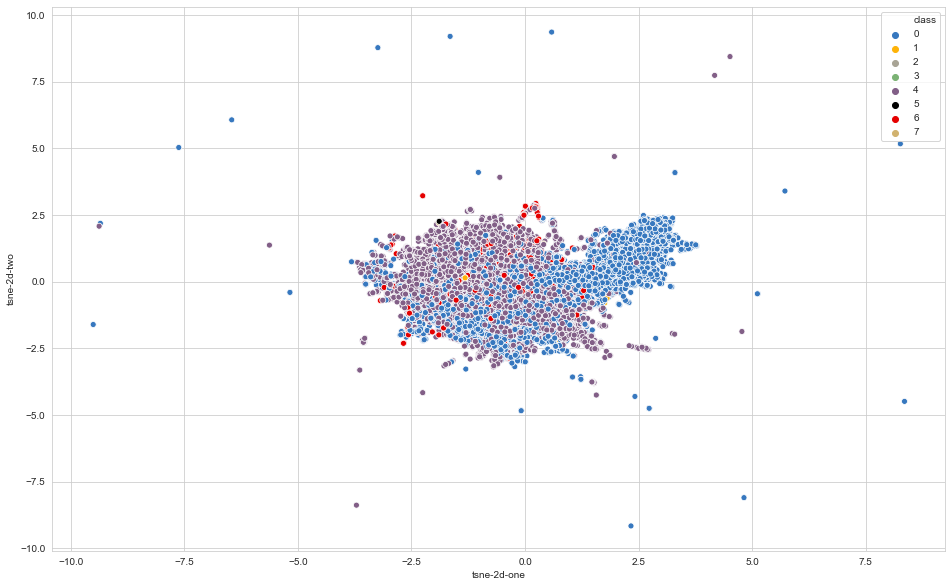

In [24]:
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=2, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette = sns.xkcd_palette(colors),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 17662 samples in 0.130s...
[t-SNE] Computed neighbors for 17662 samples in 80.395s...
[t-SNE] Computed conditional probabilities for sample 1000 / 17662
[t-SNE] Computed conditional probabilities for sample 2000 / 17662
[t-SNE] Computed conditional probabilities for sample 3000 / 17662
[t-SNE] Computed conditional probabilities for sample 4000 / 17662
[t-SNE] Computed conditional probabilities for sample 5000 / 17662
[t-SNE] Computed conditional probabilities for sample 6000 / 17662
[t-SNE] Computed conditional probabilities for sample 7000 / 17662
[t-SNE] Computed conditional probabilities for sample 8000 / 17662
[t-SNE] Computed conditional probabilities for sample 9000 / 17662
[t-SNE] Computed conditional probabilities for sample 10000 / 17662
[t-SNE] Computed conditional probabilities for sample 11000 / 17662
[t-SNE] Computed conditional probabilities for sample 12000 / 17662
[t-SNE] Computed conditional probabilities for sa

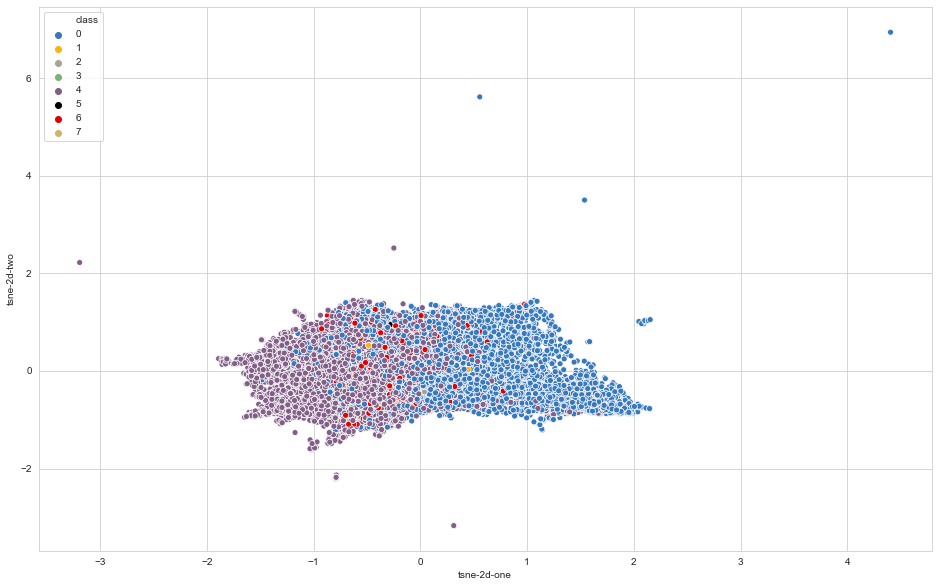

In [23]:
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette = sns.xkcd_palette(colors),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

In [ ]:
# time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=45, n_iter=250)
tsne_results = tsne.fit_transform(audio_train)
# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne['class'] = labels_train
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 4),
    data=df_tsne,
    legend="full",
#     alpha=0.3
)
print('finsihed the cell')

In [ ]:
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import MinMaxScaler


# def get_scaled_tsne_embeddings(features, perplexity, iteration):
#     embedding = TSNE(n_components=2,
#                      perplexity=perplexity,
#                      n_iter=iteration).fit_transform(features)
#     scaler = MinMaxScaler()
#     scaler.fit(embedding)
#     return scaler.transform(embedding)


# tnse_embeddings_mfccs = []
# # perplexities = [2, 5, 30, 50, 100]
# # iterations = [250, 500, 1000, 2000, 5000]
# perplexities = [2]
# iterations = [250]

# for perplexity in perplexities:
#     for iteration in iterations:
#         tsne_mfccs = get_scaled_tsne_embeddings(audio_train,
#                                                 perplexity,
#                                                 iteration)

        

In [ ]:
# tnse_embeddings_mfccs.append(tsne_mfccs)  
# mfcc_key = 'tsnemfcc{}{}'.format(i, j) 
# all_json[mfcc_key] = transform_numpy_to_json(tsne_mfccs)

In [ ]:
# fig, ax = plt.subplots(nrows=len(perplexities), 
#                        ncols=len(iterations),
#                        figsize=(30, 30))

# for i, row in enumerate(ax):
#     for j, col in enumerate(row):
#         current_plot = i * len(iterations) + j
#         col.scatter(tnse_embeddings_mfccs[current_plot].T[0], 
#                     tnse_embeddings_mfccs[current_plot].T[1], 
#                     s=1)
# plt.show()